<a href="https://colab.research.google.com/github/fovi-llc/machine-learning-for-trading/blob/main/12_gradient_boosting_machines/10_intraday_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intraday Strategy, Part 1: Feature Engineering

In this notebook, we load the high-quality NASDAQ100 minute-bar trade-and-quote data generously provided by [Algoseek](https://www.algoseek.com/) (available [here](https://www.algoseek.com/ml4t-book-data.html)) and engineer a few illustrative features.

The rich set of trade and quote information contained in the Algoseek data offers various opportunities to add inforation, e.g. about relative spreads and demand/supply imbalances, but since the data is fairly large we limit our efforts to a small number of features.

> Note that we will assume throughout that we can always buy (sell) at the first (last) trade price for a given bar at no cost and without market impact; this is unlikely to be true in reality but simplifies the example).

The next notebook will use this dataset to train a model that predicts 1-minute returns using LightGBM.

In [4]:
!wget https://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz

--2025-01-02 03:53:15--  https://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 104.18.12.149, 104.18.13.149, 2606:4700::6812:c95, ...
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|104.18.12.149|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2025-01-02 03:53:15--  https://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 104.18.13.149, 104.18.12.149, 2606:4700::6812:c95, ...
Connecting to downloads.sourceforge.net (downloads.sourceforge.net)|104.18.13.149|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cytranet-dal.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1 [following]
-

In [ ]:
%%bash
tar -xzf ta-lib-0.4.0-src.tar.gz
cd ta-lib/
./configure --prefix=/usr
make
sudo make install

In [ ]:
%pip install cython matplotlib tqdm seaborn "numpy<2" scipy ta-lib tables
# https://docs.cupy.dev/en/stable/install.html#installing-cupy
%pip install --extra-index-url https://pypi.nvidia.com cupy-cuda12x cudf-cu12

## Imports & Settings

In [6]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [7]:
import cudf
import cupy
cupy.cuda.get_device_id()

0

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
%matplotlib inline

from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd

from scipy.stats import spearmanr
import talib

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [10]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1)

## Algoseek Trade & Quote Minute Bar Data

### Data Dictionary

The Quote fields are based on changes to the NBBO ([National Best Bid Offer](https://www.investopedia.com/terms/n/nbbo.asp)) from the top-of-book price and size from
each of the exchanges.

The enhanced Trade & Quote bar fields include the following fields:
- **Field**: Name of Field.
- **Q / T**: Field based on Quotes or Trades
- **Type**: Field format
- **No Value**: Value of field when there is no value or data.
  - Note: “Never” means field should always have a value EXCEPT for the first bar of the day.
- **Description**: Description of the field.

See [docs](https://us-equity-market-data-docs.s3.amazonaws.com/algoseek.US.Equity.TAQ.Minute.Bars.pdf) for additional detail.

| id  | Field                   | Q/T  | Type                          |  No Value | Description                                                                                                                                                                                                         |
|:---:|:------------------------|:----:|:------------------------------|:---------:|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 1  | `Date`                   |      | YYYYMMDD                      | Never     | Trade Date                                                                                                                                                                                                          |
| 2  | `Ticker`                 |      | String                       | Never      | Ticker Symbol                                                                                                                                                                                                       |
| 3  | `TimeBarStart`           |      | HHMM <br>HHMMSS <br>HHMMSSMMM | Never     | For minute bars: HHMM. <br>For second bars: HHMMSS. <br>Examples<br>- One second bar 130302 is from time greater than 130301 to 130302.<br>- One minute bar 1104 is from time greater than 1103 to 1104. |
| 4  | `OpenBarTime`            | Q    | HHMMSSMMM                    | Never      | Open Time of the Bar, for example one minute:<br>11:03:00.000                                                                                                                                                       |
| 5  | `OpenBidPrice`           | Q    | Number                        | Never     | NBBO Bid Price as of bar Open                                                                                                                                                                                       |
| 6  | `OpenBidSize`            | Q    | Number                        | Never     | Total Size from all Exchanges with<br>OpenBidPrice                                                                                                                                                                  |
| 7  | `OpenAskPrice`           | Q    | Number                        | Never     | NBBO Ask Price as of bar Open                                                                                                                                                                                       |
| 8  | `OpenAskSize`            | Q    | Number                        | Never     | Total Size from all Exchange with<br>OpenAskPrice                                                                                                                                                                   |
| 9  | `FirstTradeTime`         | T    | HHMMSSMMM                     | Blank     | Time of first Trade                                                                                                                                                                                                 |
| 10 | `FirstTradePrice`        | T    | Number                        | Blank     | Price of first Trade                                                                                                                                                                                                |
| 11 | `FirstTradeSize`         | T    | Number                        | Blank     | Number of shares of first trade                                                                                                                                                                                     |
| 12 | `HighBidTime`            | Q    | HHMMSSMMM                     | Never     | Time of highest NBBO Bid Price                                                                                                                                                                                      |
| 13 | `HighBidPrice`           | Q    | Number                        | Never     | Highest NBBO Bid Price                                                                                                                                                                                              |
| 14 | `HighBidSize`            | Q    | Number                        | Never     | Total Size from all Exchanges with HighBidPrice                                                                                                                                                                  |
| 15 | `AskPriceAtHighBidPrice` | Q    | Number                        | Never     | Ask Price at time of Highest Bid Price                                                                                                                                                                              |
| 16 | `AskSizeAtHighBidPrice`  | Q    | Number                        | Never     | Total Size from all Exchanges with `AskPriceAtHighBidPrice`                                                                                                                                                        |
| 17 | `HighTradeTime`          | T    | HHMMSSMMM                     | Blank     | Time of Highest Trade                                                                                                                                                                                               |
| 18 | `HighTradePrice`         | T    | Number                        | Blank     | Price of highest Trade                                                                                                                                                                                              |
| 19 | `HighTradeSize`          | T    | Number                        | Blank     | Number of shares of highest trade                                                                                                                                                                                   |
| 20 | `LowBidTime`             | Q    | HHMMSSMMM                     | Never     | Time of lowest Bid                                                                                                                                                                                                  |
| 21 | `LowBidPrice`            | Q    | Number                        | Never     | Lowest NBBO Bid price of bar.                                                                                                                                                                                       |
| 22 | `LowBidSize`             | Q    | Number                        | Never     | Total Size from all Exchanges with `LowBidPrice`                                                                                                                                                                   |
| 23 | `AskPriceAtLowBidPrice`  | Q    | Number                        | Never     | Ask Price at lowest Bid price                                                                                                                                                                                       |
| 24  | `AskSizeAtLowBidPrice`  | Q    | Number                        | Never     | Total Size from all Exchanges with `AskPriceAtLowBidPrice`                                                                                                                                                                                       |
| 25  | `LowTradeTime`          | T    | HHMMSSMMM                     | Blank     | Time of lowest Trade                                                                                                                                                                                                                             |
| 26  | `LowTradePrice`         | T    | Number                        | Blank     | Price of lowest Trade                                                                                                                                                                                                                            |
| 27  | `LowTradeSize`          | T    | Number                        | Blank     | Number of shares of lowest trade                                                                                                                                                                                                                 |
| 28  | `CloseBarTime`          | Q    | HHMMSSMMM                     | Never     | Close Time of the Bar, for example one minute: 11:03:59.999                                                                                                                                                                                      |
| 29  | `CloseBidPrice`         | Q    | Number                        | Never     | NBBO Bid Price at bar Close                                                                                                                                                                                                                      |
| 30  | `CloseBidSize`          | Q    | Number                        | Never     | Total Size from all Exchange with `CloseBidPrice`                                                                                                                                                                                                |
| 31  | `CloseAskPrice`         | Q    | Number                        | Never     | NBBO Ask Price at bar Close                                                                                                                                                                                                                      |
| 32  | `CloseAskSize`          | Q    | Number                        | Never     | Total Size from all Exchange with `CloseAskPrice`                                                                                                                                                                                                |
| 33  | `LastTradeTime`         | T    | HHMMSSMMM                     | Blank     | Time of last Trade                                                                                                                                                                                                                               |
| 34  | `LastTradePrice`        | T    | Number                        | Blank     | Price of last Trade                                                                                                                                                                                                                              |
| 35  | `LastTradeSize`         | T    | Number                        | Blank     | Number of shares of last trade                                                                                                                                                                                                                   |
| 36  | `MinSpread`             | Q    | Number                        | Never     | Minimum Bid-Ask spread size. This may be 0 if the market was crossed during the bar.<br/>If negative spread due to back quote, make it 0.                                                                                                            |
| 37  | `MaxSpread`             | Q    | Number                        | Never     | Maximum Bid-Ask spread in bar                                                                                                                                                                                                                    |
| 38  | `CancelSize`            | T    | Number                        | 0         | Total shares canceled. Default=blank                                                                                                                                                                                                             |
| 39  | `VolumeWeightPrice`     | T    | Number                        | Blank     | Trade Volume weighted average price <br>Sum((`Trade1Shares`*`Price`)+(`Trade2Shares`*`Price`)+…)/`TotalShares`. <br>Note: Blank if no trades.                                                                                                        |
| 40  | `NBBOQuoteCount`        | Q    | Number                        | 0         | Number of Bid and Ask NNBO quotes during bar period.                                                                                                                                                                                             |
| 41  | `TradeAtBid`            | Q,T  | Number                        | 0         | Sum of trade volume that occurred at or below the bid (a trade reported/printed late can be below current bid).                                                                                                                                  |
| 42  | `TradeAtBidMid`         | Q,T  | Number                        | 0         | Sum of trade volume that occurred between the bid and the mid-point:<br/>(Trade Price > NBBO Bid ) & (Trade Price < NBBO Mid )                                                                                                                       |
| 43  | `TradeAtMid`            | Q,T  | Number                        | 0         | Sum of trade volume that occurred at mid.<br/>TradePrice = NBBO MidPoint                                                                                                                                                                             |
| 44  | `TradeAtMidAsk`         | Q,T  | Number                        | 0         | Sum of ask volume that occurred between the mid and ask:<br/>(Trade Price > NBBO Mid) & (Trade Price < NBBO Ask)                                                                                                                                     |
| 45  | `TradeAtAsk`            | Q,T  | Number                        | 0         | Sum of trade volume that occurred at or above the Ask.                                                                                                                                                                                           |
| 46  | `TradeAtCrossOrLocked`  | Q,T  | Number                        | 0         | Sum of trade volume for bar when national best bid/offer is locked or crossed. <br>Locked is Bid = Ask <br>Crossed is Bid > Ask                                                                                                                  |
| 47  | `Volume`                | T    | Number                        | 0         | Total number of shares traded                                                                                                                                                                                                                    |
| 48  | `TotalTrades`           | T    | Number                        | 0         | Total number of trades                                                                                                                                                                                                                           |
| 49  | `FinraVolume`           | T    | Number                        | 0         | Number of shares traded that are reported by FINRA. <br/>Trades reported by FINRA are from broker-dealer internalization, dark pools, Over-The-Counter, etc. <br/>FINRA trades represent volume that is hidden or not public available to trade.         |
| 50  | `UptickVolume`          | T    | Integer                       | 0         | Total number of shares traded with upticks during bar.<br/>An uptick = ( trade price > last trade price )                                                                                                                                                                                                                               |
| 51  | `DowntickVolume`        | T    | Integer                       | 0         | Total number of shares traded with downticks during bar.<br/>A downtick = ( trade price < last trade price )                                                                                                                                                                                                                            |
| 52  | `RepeatUptickVolume`    | T    | Integer                       | 0         | Total number of shares where trade price is the same (repeated) and last price change was up during bar. <br/>Repeat uptick = ( trade price == last trade price ) & (last tick direction == up )                                                                                                                                         |
| 53  | `RepeatDowntickVolume`  | T    | Integer                       | 0         | Total number of shares where trade price is the same (repeated) and last price change was down during bar. <br/>Repeat downtick = ( trade price == last trade price ) & (last tick direction == down )                                                                                                                                   |
| 54  | `UnknownVolume`         | T    | Integer                       | 0         | When the first trade of the day takes place, the tick direction is “unknown” as there is no previous Trade to compare it to.<br/>This field is the volume of the first trade after 4am and acts as an initiation value for the tick volume directions.<br/>In future this bar will be renamed to `UnkownTickDirectionVolume` .  |

### Notes

**Empty Fields**

An empty field has no value and is “Blank” , for example FirstTradeTime and there are no trades during the bar period.
The field `Volume` measuring total number of shares traded in bar will be `0` if there are no Trades (see `No Value` column above for each field).

**No Bid/Ask/Trade OHLC**

During a bar timeframe there may not be a change in the NBBO or an actual Trade.
For example, there can be a bar with OHLC Bid/Ask but no Trade OHLC.

**Single Event**

For bars with only one trade, one NBBO bid or one NBBO ask then Open/High/Low/Close price,size andtime will be the same.

**`AskPriceAtHighBidPrice`, `AskSizeAtHighBidPrice`, `AskPriceAtLowBidPrice`, `AskSizeAtLowBidPrice` Fields**

To provide consistent Bid/Ask prices at a point in time while showing the low/high Bid/Ask for the bar, AlgoSeek uses the low/high `Bid` and the corresponding `Ask` at that price.

### FAQ

**Why are Trade Prices often inside the Bid Price to Ask Price range?**

The Low/High Bid/Ask is the low and high NBBO price for the bar range.
Very often a Trade may not occur at these prices as the price may only last a few seconds or executions are being crossed at mid-point due to hidden order types that execute at mid-point or as price improvement over current `Bid`/`Ask`.

**How to get exchange tradable shares?**

To get the exchange tradable volume in a bar subtract `Volume` from `FinraVolume`.
- `Volume` is the total number of shares traded.
- ``FinraVolume`` is the total number of shares traded that are reported as executions by FINRA.

When a trade is done that is off the listed exchanges, it must be reported to FINRA by the brokerage firm or dark pool. Examples include:
- internal crosses by broker dealer
- over-the-counter block trades, and
- dark pool executions.

## Data prep

We use the 'Trade and Quote' dataset - see [documentation](https://www.algoseek.com/old_static/files/documentation/equity_and_etf_etn/AlgoSeek.US.Equity.TradeAndQuotes.OHLC.Bars.1.5.pdf) for details on the definition of the numerous fields.

In [11]:
tcols = ['openbartime',
         'firsttradetime',
         'highbidtime',
         'highasktime',
         'hightradetime',
         'lowbidtime',
         'lowasktime',
         'lowtradetime',
         'closebartime',
         'lasttradetime']

In [12]:
drop_cols = ['unknowntickvolume',
             'cancelsize',
             'tradeatcrossorlocked']

In [13]:
keep = ['firsttradeprice',
        'hightradeprice',
        'lowtradeprice',
        'lasttradeprice',
        'minspread',
        'maxspread',
        'volumeweightprice',
        'nbboquotecount',
        'tradeatbid',
        'tradeatbidmid',
        'tradeatmid',
        'tradeatmidask',
        'tradeatask',
        'volume',
        'totaltrades',
        'finravolume',
        'finravolumeweightprice',
        'uptickvolume',
        'downtickvolume',
        'repeatuptickvolume',
        'repeatdowntickvolume',
        'tradetomidvolweight',
        'tradetomidvolweightrelative']

We will shorten most of the field names to reduce typing:

In [14]:
columns = {'volumeweightprice'          : 'price',
           'finravolume'                : 'fvolume',
           'finravolumeweightprice'     : 'fprice',
           'uptickvolume'               : 'up',
           'downtickvolume'             : 'down',
           'repeatuptickvolume'         : 'rup',
           'repeatdowntickvolume'       : 'rdown',
           'firsttradeprice'            : 'first',
           'hightradeprice'             : 'high',
           'lowtradeprice'              : 'low',
           'lasttradeprice'             : 'last',
           'nbboquotecount'             : 'nbbo',
           'totaltrades'                : 'ntrades',
           'openbidprice'               : 'obprice',
           'openbidsize'                : 'obsize',
           'openaskprice'               : 'oaprice',
           'openasksize'                : 'oasize',
           'highbidprice'               : 'hbprice',
           'highbidsize'                : 'hbsize',
           'highaskprice'               : 'haprice',
           'highasksize'                : 'hasize',
           'lowbidprice'                : 'lbprice',
           'lowbidsize'                 : 'lbsize',
           'lowaskprice'                : 'laprice',
           'lowasksize'                 : 'lasize',
           'closebidprice'              : 'cbprice',
           'closebidsize'               : 'cbsize',
           'closeaskprice'              : 'caprice',
           'closeasksize'               : 'casize',
           'firsttradesize'             : 'firstsize',
           'hightradesize'              : 'highsize',
           'lowtradesize'               : 'lowsize',
           'lasttradesize'              : 'lastsize',
           'tradetomidvolweight'        : 'volweight',
           'tradetomidvolweightrelative': 'volweightrel'}

The Algoseek minute-bar data comes in compressed csv files that contain the data for one symbol and day, organized in three directories for each year (2015-17). The function `extract_and_combine_data` reads the ~80K source files and combines them into a single `hdf5` file for faster access.

>The data is fairly large (>8GB), and if you run into memory constraints, please modify the code to process the data in smaller chunks. One options is to iterate over the three directories containing data for a single year only, and storing each year separately.

In [15]:
import os
if not os.environ.get("PROJECTS_DIR"):
    os.environ["PROJECTS_DIR"] = "/media/nas20t1/Projects"
os.environ.get("PROJECTS_DIR")

'/media/nas20t1/Projects'

In [16]:
workspace_path = Path(os.environ.get("PROJECTS_DIR"), "machine-learning-for-trading")

nasdaq_path = workspace_path / 'data/nasdaq100'

algoseek_path = nasdaq_path / 'algoseek-longer.h5'

In [17]:
# %wget -P "$PROJECTS_DIR/machine-learning-for-trading/data" https://algoseek-public.s3.amazonaws.com/nasdaq100-1min.zip 

In [18]:
def extract_and_combine_data():
    data = []
    # ~80K files to process
    for f in tqdm(list(nasdaq_path.glob('*/**/*.csv.gz'))):
        data.append(pd.read_csv(f, parse_dates=[['Date', 'TimeBarStart']])
                    .rename(columns=str.lower)
                    .drop(tcols + drop_cols, axis=1)
                    .rename(columns=columns)
                    .set_index('date_timebarstart')
                    .sort_index()
                    .between_time('9:30', '12:30')
                    .set_index('ticker', append=True)
                    .swaplevel()
                    .rename(columns=lambda x: x.replace('tradeat', 'at')))
    data = pd.concat(data).apply(pd.to_numeric, downcast='integer')
    data.index.rename(['ticker', 'date_time'])
    print(data.info(show_counts=True))
    data.to_hdf(algoseek_path, 'min_taq')

In [19]:
if not algoseek_path.exists():
  extract_and_combine_data()

## Loading Algoseek Data

In [22]:
ohlcv_cols = ['first', 'high', 'low', 'last', 'price', 'volume']

In [23]:
data_cols = ohlcv_cols + ['up', 'down', 'rup', 'rdown', 'atask', 'atbid']

In [26]:
algoseek_path

PosixPath('/media/nas20t1/Projects/machine-learning-for-trading/data/nasdaq100/algoseek-longer.h5')

In [27]:
# This is in PyPi tables
with pd.HDFStore(algoseek_path) as store:
    df = store['min_taq'].loc[:, data_cols].sort_index()

In [28]:
df.index.rename(['ticker', 'date_time'], inplace=True)

In [29]:
df

first   high    low     last     price  volume  \
ticker date_time                                                              
AAL    2015-01-02 09:30:00  54.230  54.60  54.16  54.4600  54.29077  322952   
       2015-01-02 09:31:00  54.460  54.53  54.03  54.0300  54.25423   41021   
       2015-01-02 09:32:00  54.030  54.38  54.03  54.3300  54.21918   38838   
       2015-01-02 09:33:00  54.350  54.37  54.02  54.0200  54.17345   28495   
       2015-01-02 09:34:00  54.030  54.47  54.03  54.4500  54.25115   33939   
...                            ...    ...    ...      ...       ...     ...   
YHOO   2017-06-16 12:26:00  52.270  52.28  52.27  52.2800  52.27499   44661   
       2017-06-16 12:27:00  52.280  52.28  52.27  52.2700  52.27085   28929   
       2017-06-16 12:28:00  52.275  52.30  52.27  52.2950  52.28527  101998   
       2017-06-16 12:29:00  52.291  52.30  52.25  52.2500  52.27528   50636   
       2017-06-16 12:30:00  52.245  52.25  52.23  52.2389  52.23807   33697   

                               up    down     rup  rdown   atask   atbid  
ticker date_time                                                          
AAL    2015-01-02 09:30:00  38994  212658  103880  28552  121743  219484  
       2015-01-02 09:31:00  21769   26602   11350  24854   13539   35267  
       2015-01-02 09:32:00  23979   18662   26748   9663   34225   15960  
       2015-01-02 09:33:00  14918   20112    7143  14687    6819   17940  
       2015-01-02 09:34:00  13292    7437   29723   3664   30543    9307  
...                           ...     ...     ...    ...     ...     ...  
YHOO   2017-06-16 12:26:00   6505    5967   20908  26378   24434   26578  
       2017-06-16 12:27:00   5480    6225    5023  30428    5800   32528  
       2017-06-16 12:28:00  31558    9850   77951  42382   74346   39753  
       2017-06-16 12:29:00   6424    5549    9334  48119   15782   43701  
       2017-06-16 12:30:00   4702    4716    8889  24991   11810   27352  

[14514933 rows x 12 columns]

In [30]:
df['date'] = pd.to_datetime(df.index.get_level_values('date_time').date)

We persist the reduced dataset:

In [31]:
df.to_hdf(algoseek_path, 'data')

In [32]:
df = pd.read_hdf(algoseek_path, 'data')

In [33]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 14514933 entries, ('AAL', Timestamp('2015-01-02 09:30:00')) to ('YHOO', Timestamp('2017-06-16 12:30:00'))
Data columns (total 13 columns):
 #   Column  Non-Null Count     Dtype         
---  ------  --------------     -----         
 0   first   14364397 non-null  float64       
 1   high    14364397 non-null  float64       
 2   low     14364397 non-null  float64       
 3   last    14364397 non-null  float64       
 4   price   14107591 non-null  float64       
 5   volume  14514933 non-null  int32         
 6   up      14514933 non-null  int32         
 7   down    14514933 non-null  int32         
 8   rup     14514933 non-null  int32         
 9   rdown   14514933 non-null  int32         
 10  atask   14514933 non-null  int32         
 11  atbid   14514933 non-null  int32         
 12  date    14514933 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int32(7)
memory usage: 1.1+ GB


## Feature Engineering

All of the features above were normalized in a standard fashion
by subtracting their means, dividing by their standard deviations, and time-averaging over a recent
interval. In order to obtain a finite state space, features were discretized into bins in multiples of
standard deviation units

We will compute feature per ticker or ticker and date:

In [34]:
by_ticker = df.sort_index().groupby('ticker', group_keys=False)
by_ticker_date = df.sort_index().groupby(['ticker', 'date'])

Create empty `DataFrame` with original ticker/timestamp index to hold our features:

In [35]:
data = pd.DataFrame(index=df.index)

In [36]:
data['date'] = pd.factorize(df['date'], sort=True)[0]

In [37]:
data['minute'] = pd.to_timedelta(data.index.get_level_values('date_time').time.astype(str))
data.minute = (data.minute.dt.seconds.sub(data.minute.dt.seconds.min()).div(60).astype(int))

### Lagged Returns

We create lagged returns with respect to first and last price per bar for each the past 10 minutes:

In [38]:
data[f'ret1min'] = df['last'].div(df['first']).sub(1)

1-min returns have rather heavy tails:

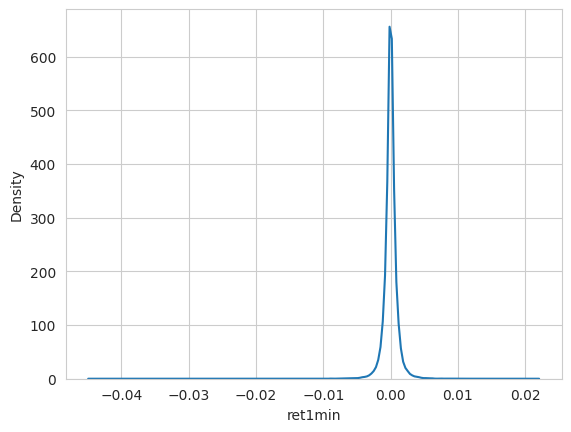

In [39]:
sns.kdeplot(data.ret1min.sample(n=100000));

In [40]:
data.ret1min.describe(percentiles=np.arange(.1, 1, .1)).iloc[1:].apply(lambda x: f'{x:.3%}')

mean     -0.000%
std       0.106%
min     -12.448%
10%      -0.094%
20%      -0.052%
30%      -0.029%
40%      -0.012%
50%       0.000%
60%       0.012%
70%       0.028%
80%       0.051%
90%       0.092%
max      13.392%
Name: ret1min, dtype: object

In [41]:
print(f'Skew: {data.ret1min.skew():.2f} | Kurtosis: {data.ret1min.kurtosis():.2f}')

Skew: 0.15 | Kurtosis: 271.56


Intra-bar price moves with the highest returns:

In [42]:
data.join(df[['first', 'last']]).nlargest(10, columns=['ret1min'])

,,date,minute,ret1min,first,last
ticker,date_time,,,,,
TSCO,2016-12-22 10:01:00,498,31,0.133921,68.1000,77.2200
LILA,2015-07-02 09:39:00,125,9,0.121998,50.0001,56.1000
BIDU,2015-08-24 09:32:00,161,2,0.119729,111.2300,124.5475
CELG,2015-08-24 09:35:00,161,5,0.100645,93.0000,102.3600
LILAK,2015-07-02 09:38:00,125,8,0.098778,50.0101,54.9500
CTRP,2017-12-11 10:51:00,741,81,0.097899,43.3100,47.5500
LMCK,2016-02-23 09:30:00,286,0,0.095641,30.7400,33.6800
LILAK,2015-07-02 09:37:00,125,7,0.094581,50.0100,54.7400
CHKP,2017-01-24 12:22:00,518,172,0.084598,90.9000,98.5900


We compute similarly for the remaining periods:

In [43]:
for t in tqdm(range(2, 11)):
    data[f'ret{t}min'] = df['last'].div(by_ticker_date['first'].shift(t-1)).sub(1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  4.57it/s]


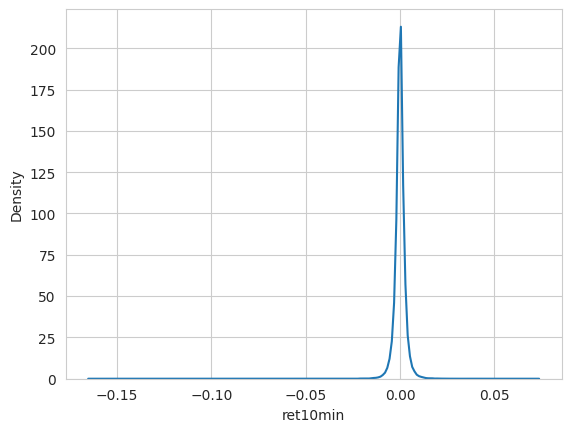

In [44]:
sns.kdeplot(data.ret10min.sample(n=100000));

In [45]:
# saved_data = data.copy()

### Forward Returns

We obtain our 1-min forward return target by shifting the one-period return by one minute into the past (which implies the assumption that we always enter and exit a position at those prices, also ignoring trading cost and potential market impact):

In [46]:
# data = saved_data.copy()
# data.sort_index(inplace=True)
# data['fwd1min'] = (data
#                    .groupby(['ticker', 'date'])
#                    .ret1min
#                    .shift(-1))

In [47]:
# data = saved_data.copy()
# data['fwd1min'] = (data
#                    .sort_index()
#                    .groupby(['ticker', 'date'])
#                    .ret1min
#                    .shift(-1))

In [48]:
%%cython

import numpy as np

def retwin(s):
    # s.info()
    # print(s)
    # print(s.ret10min)
    win = s.ret10min
    if np.isnan(win):
        return win
    for ret in [s.ret9min, s.ret8min, s.ret7min, s.ret6min, s.ret5min, s.ret4min, s.ret3min, s.ret2min, s.ret1min]:
        if np.isnan(ret):
            break
        if ret < 0:
            break
        if ret > win:
            win = ret
    # print(f"{win=}")
    # if not s.isna().any():
    # raise ValueError()
    return win

In [49]:
# data = saved_data.copy()
data.sort_index(inplace=True)

fwd_window_size = 10

data['retwin'] = data.apply(retwin, axis=1)

data['fwdwin'] = (data
                   .groupby(['ticker', 'date'])
                   .retwin
                   .shift(-fwd_window_size))

In [50]:
data

date  minute   ret1min   ret2min   ret3min  \
ticker date_time                                                         
AAL    2015-01-02 09:30:00     0       0  0.004241       NaN       NaN   
       2015-01-02 09:31:00     0       1 -0.007896 -0.003688       NaN   
       2015-01-02 09:32:00     0       2  0.005552 -0.002387  0.001844   
       2015-01-02 09:33:00     0       3 -0.006072 -0.000185 -0.008079   
       2015-01-02 09:34:00     0       4  0.007773  0.001840  0.007773   
...                          ...     ...       ...       ...       ...   
YHOO   2017-06-16 12:26:00   618     176  0.000191 -0.000191 -0.000382   
       2017-06-16 12:27:00   618     177 -0.000191  0.000000 -0.000382   
       2017-06-16 12:28:00   618     178  0.000383  0.000287  0.000478   
       2017-06-16 12:29:00   618     179 -0.000784 -0.000478 -0.000574   
       2017-06-16 12:30:00   618     180 -0.000117 -0.000996 -0.000691   

                             ret4min   ret5min   ret6min   ret7min   ret8min  \
ticker date_time                                                               
AAL    2015-01-02 09:30:00       NaN       NaN       NaN       NaN       NaN   
       2015-01-02 09:31:00       NaN       NaN       NaN       NaN       NaN   
       2015-01-02 09:32:00       NaN       NaN       NaN       NaN       NaN   
       2015-01-02 09:33:00 -0.003872       NaN       NaN       NaN       NaN   
       2015-01-02 09:34:00 -0.000184  0.004057       NaN       NaN       NaN   
...                              ...       ...       ...       ...       ...   
YHOO   2017-06-16 12:26:00 -0.000191  0.000191  0.001341  0.000766  0.000287   
       2017-06-16 12:27:00 -0.000574 -0.000382  0.000000  0.001149  0.000574   
       2017-06-16 12:28:00  0.000096 -0.000096  0.000096  0.000478  0.001628   
       2017-06-16 12:29:00 -0.000383 -0.000765 -0.000956 -0.000765 -0.000383   
       2017-06-16 12:30:00 -0.000786 -0.000595 -0.000977 -0.001168 -0.000977   

                             ret9min  ret10min    retwin    fwdwin  
ticker date_time                                                    
AAL    2015-01-02 09:30:00       NaN       NaN       NaN  0.008203  
       2015-01-02 09:31:00       NaN       NaN       NaN  0.007773  
       2015-01-02 09:32:00       NaN       NaN       NaN  0.008884  
       2015-01-02 09:33:00       NaN       NaN       NaN  0.009624  
       2015-01-02 09:34:00       NaN       NaN       NaN  0.006647  
...                              ...       ...       ...       ...  
YHOO   2017-06-16 12:26:00  0.000191  0.000000  0.001341       NaN  
       2017-06-16 12:27:00  0.000096  0.000000  0.001149       NaN  
       2017-06-16 12:28:00  0.001053  0.000574  0.001628       NaN  
       2017-06-16 12:29:00  0.000766  0.000191  0.000766       NaN  
       2017-06-16 12:30:00 -0.000595  0.000554  0.000554       NaN  

[14514933 rows x 14 columns]

In [51]:
data = data.dropna(subset=['fwdwin'])

In [52]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 13452358 entries, ('AAL', Timestamp('2015-01-02 09:30:00')) to ('YHOO', Timestamp('2017-06-16 12:20:00'))
Data columns (total 14 columns):
 #   Column    Non-Null Count     Dtype  
---  ------    --------------     -----  
 0   date      13452358 non-null  int64  
 1   minute    13452358 non-null  int64  
 2   ret1min   13350557 non-null  float64
 3   ret2min   13180747 non-null  float64
 4   ret3min   13102981 non-null  float64
 5   ret4min   13025556 non-null  float64
 6   ret5min   12949249 non-null  float64
 7   ret6min   12871879 non-null  float64
 8   ret7min   12793437 non-null  float64
 9   ret8min   12715802 non-null  float64
 10  ret9min   12638377 non-null  float64
 11  ret10min  12560968 non-null  float64
 12  retwin    12560968 non-null  float64
 13  fwdwin    13452358 non-null  float64
dtypes: float64(12), int64(2)
memory usage: 1.5+ GB


In [53]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 13452358 entries, ('AAL', Timestamp('2015-01-02 09:30:00')) to ('YHOO', Timestamp('2017-06-16 12:20:00'))
Data columns (total 14 columns):
 #   Column    Non-Null Count     Dtype  
---  ------    --------------     -----  
 0   date      13452358 non-null  int64  
 1   minute    13452358 non-null  int64  
 2   ret1min   13350557 non-null  float64
 3   ret2min   13180747 non-null  float64
 4   ret3min   13102981 non-null  float64
 5   ret4min   13025556 non-null  float64
 6   ret5min   12949249 non-null  float64
 7   ret6min   12871879 non-null  float64
 8   ret7min   12793437 non-null  float64
 9   ret8min   12715802 non-null  float64
 10  ret9min   12638377 non-null  float64
 11  ret10min  12560968 non-null  float64
 12  retwin    12560968 non-null  float64
 13  fwdwin    13452358 non-null  float64
dtypes: float64(12), int64(2)
memory usage: 1.5+ GB


In [54]:
data.loc['AAL'].dropna().head(15)

,date,minute,ret1min,ret2min,ret3min,ret4min,ret5min,ret6min,ret7min,ret8min,ret9min,ret10min,retwin,fwdwin
date_time,,,,,,,,,,,,,,
2015-01-02 09:39:00,0,9,0.001287,0.005170,0.002397,0.001472,0.000368,0.007588,0.001656,0.007588,-0.000367,0.003872,0.003872,0.000184
2015-01-02 09:40:00,0,10,0.000794,0.001898,0.005783,0.003009,0.002082,0.000978,0.008203,0.002267,0.008203,0.000242,0.008203,-0.000367
2015-01-02 09:41:00,0,11,0.000000,0.000367,0.001471,0.005355,0.002581,0.001656,0.000551,0.007773,0.001840,0.007773,0.007773,-0.000918
2015-01-02 09:42:00,0,12,0.001102,0.001102,0.001470,0.002575,0.006462,0.003686,0.002759,0.001654,0.008884,0.002944,0.008884,-0.004036
2015-01-02 09:43:00,0,13,0.000734,0.001837,0.001837,0.002205,0.003311,0.007201,0.004423,0.003495,0.002389,0.009624,0.009624,-0.001834
2015-01-02 09:44:00,0,14,0.000000,0.000183,0.001286,0.001286,0.001653,0.002759,0.006647,0.003870,0.002943,0.001838,0.006647,-0.003081
2015-01-02 09:45:00,0,15,-0.000367,-0.000183,0.000000,0.001102,0.001102,0.001470,0.002575,0.006462,0.003686,0.002759,0.006462,-0.000921
2015-01-02 09:46:00,0,16,0.001096,0.000365,0.000548,0.000732,0.001835,0.001835,0.002203,0.003309,0.007199,0.004421,0.007199,-0.001430
2015-01-02 09:47:00,0,17,-0.000367,0.000730,0.000000,0.000183,0.000367,0.001469,0.001469,0.001837,0.002943,0.006832,0.006832,0.005158


### Normalized up/downtick volume

In [55]:
for f in ['up', 'down', 'rup', 'rdown']:
    data[f] = df.loc[:, f].div(df.volume).replace(np.inf, np.nan)

In [56]:
data.loc[:, ['rup', 'up', 'rdown', 'down']].describe(deciles)

,rup,up,rdown,down
count,1.313938e+07,1.313938e+07,1.313938e+07,1.313938e+07
mean,4.851789e-01,7.112316e-01,4.905786e-01,7.238196e-01
std,1.170398e+01,3.185352e+01,9.625501e+00,2.987423e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
10%,0.000000e+00,7.163324e-02,0.000000e+00,7.326007e-02
20%,1.024590e-01,1.204052e-01,1.076426e-01,1.229105e-01
30%,1.967324e-01,1.650246e-01,2.032004e-01,1.679587e-01
40%,2.783184e-01,2.116500e-01,2.868217e-01,2.160467e-01
50%,3.563452e-01,2.643913e-01,3.658882e-01,2.700000e-01
60%,4.381398e-01,3.283936e-01,4.476393e-01,3.336013e-01


### Balance of Power

In [57]:
data['BOP'] = (by_ticker.apply(lambda x: talib.BOP(x['first'],
                                                   x.high,
                                                   x.low,
                                                   x['last'])))

###  Commodity Channel Index

In [58]:
data['CCI'] = (by_ticker.apply(lambda x: talib.CCI(x.high,
                                          x.low,
                                          x['last'],
                                          timeperiod=14)))

### Money Flow Index

In [59]:
data['MFI'] = (by_ticker.apply(lambda x: talib.MFI(x.high,
                                          x.low,
                                          x['last'],
                                          x.volume,
                                          timeperiod=14)))

In [60]:
data[['BOP', 'CCI', 'MFI']].describe(deciles)

,BOP,CCI,MFI
count,1.335056e+07,1.248804e+07,1.345046e+07
mean,-3.051297e-03,-1.923987e-02,4.993434e+01
std,6.261048e-01,1.099392e+02,1.997681e+01
min,-1.000000e+00,-4.666667e+02,-5.535183e-09
10%,-8.888889e-01,-1.369974e+02,2.344460e+01
20%,-6.657178e-01,-9.965922e+01,3.190482e+01
30%,-4.500000e-01,-6.948578e+01,3.846770e+01
40%,-2.000000e-01,-3.764855e+01,4.430268e+01
50%,0.000000e+00,2.426243e-11,4.985690e+01
60%,1.882427e-01,3.753501e+01,5.542986e+01


### Stochastic RSI

In [61]:
data['STOCHRSI'] = (by_ticker.apply(lambda x: talib.STOCHRSI(x['last'].ffill(),
                                                             timeperiod=14,
                                                             fastk_period=14,
                                                             fastd_period=3,
                                                             fastd_matype=0)[0]))

### Stochastic Oscillator

In [62]:
def compute_stoch(x, fastk_period=14, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0):
    slowk, slowd = talib.STOCH(x.high.ffill(), x.low.ffill(), x['last'].ffill(),
                               fastk_period=fastk_period,
                               slowk_period=slowk_period,
                               slowk_matype=slowk_matype,
                               slowd_period=slowd_period,
                               slowd_matype=slowd_matype)
    return pd.DataFrame({'slowd': slowd,
                         'slowk': slowk},
                        index=x.index)

In [63]:
data = data.join(by_ticker.apply(compute_stoch))

### Average True Range

In [64]:
data['NATR'] = by_ticker.apply(lambda x: talib.NATR(x.high.ffill(),
                                                    x.low.ffill(),
                                                    x['last'].ffill()))

### Transaction Volume by price point

In [65]:
data['trades_bid_ask'] = df.atask.sub(df.atbid).div(df.volume).replace((np.inf, -np.inf), np.nan)

In [66]:
del df

In [67]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 13452358 entries, ('AAL', Timestamp('2015-01-02 09:30:00')) to ('YHOO', Timestamp('2017-06-16 12:20:00'))
Data columns (total 26 columns):
 #   Column          Non-Null Count     Dtype  
---  ------          --------------     -----  
 0   date            13452358 non-null  int64  
 1   minute          13452358 non-null  int64  
 2   ret1min         13350557 non-null  float64
 3   ret2min         13180747 non-null  float64
 4   ret3min         13102981 non-null  float64
 5   ret4min         13025556 non-null  float64
 6   ret5min         12949249 non-null  float64
 7   ret6min         12871879 non-null  float64
 8   ret7min         12793437 non-null  float64
 9   ret8min         12715802 non-null  float64
 10  ret9min         12638377 non-null  float64
 11  ret10min        12560968 non-null  float64
 12  retwin          12560968 non-null  float64
 13  fwdwin          13452358 non-null  float64
 14  up              13139376 non-null  flo

### Evaluate features

In [68]:
features = ['ret1min', 'ret2min', 'ret3min', 'ret4min', 'ret5min',
            'ret6min', 'ret7min', 'ret8min', 'ret9min', 'ret10min',
            'retwin',
            'rup', 'up', 'down', 'rdown', 'BOP', 'CCI', 'MFI', 'STOCHRSI',
            'slowk', 'slowd', 'trades_bid_ask']

In [69]:
sample = data.sample(n=100000)

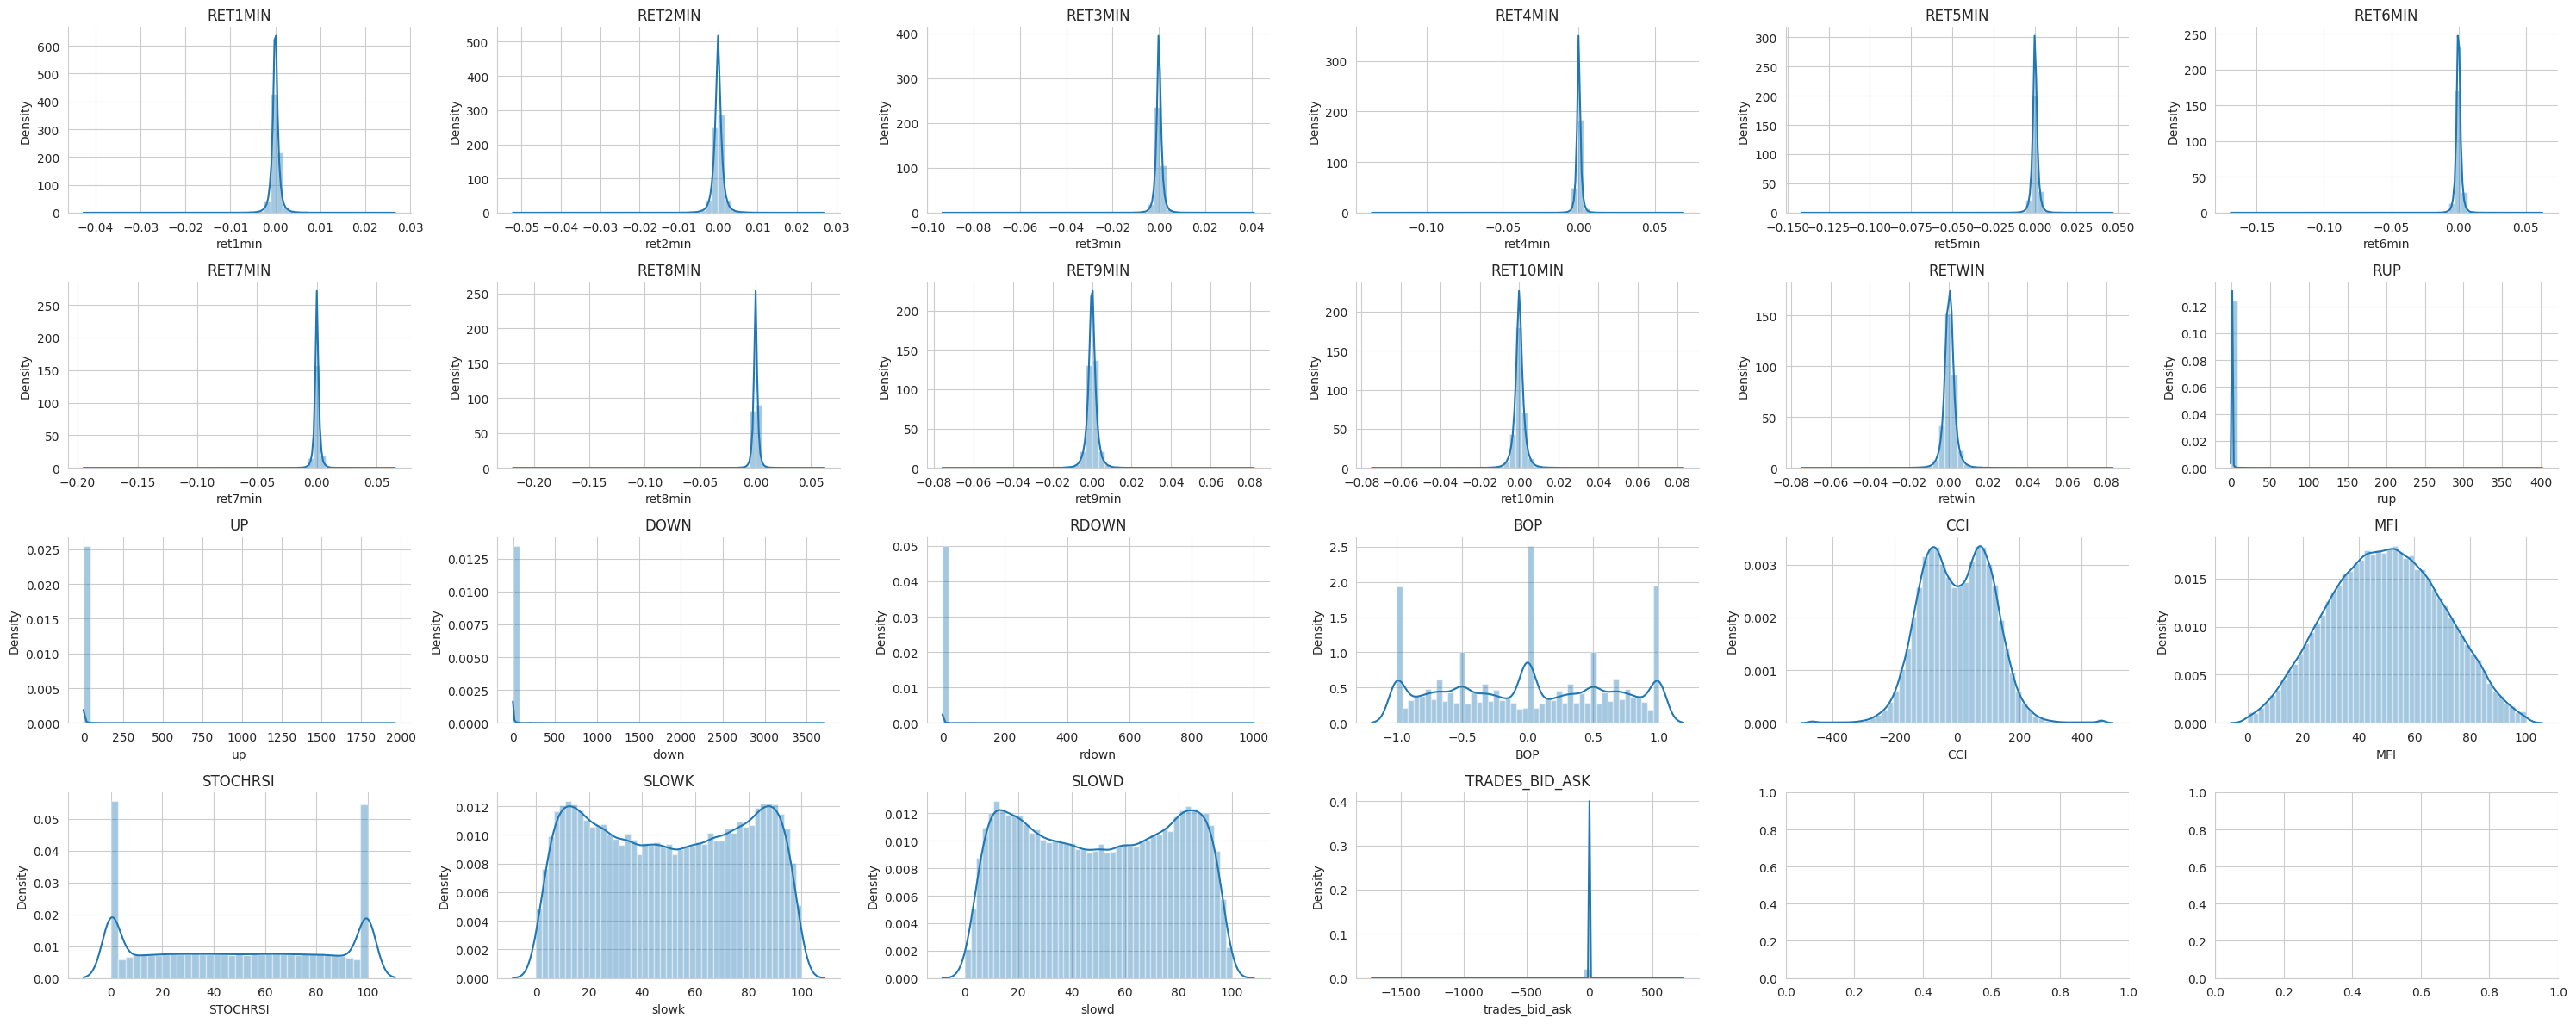

In [70]:
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(30, 12))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.distplot(sample[feature], ax=axes[i])
    axes[i].set_title(feature.upper())

sns.despine()
fig.tight_layout()

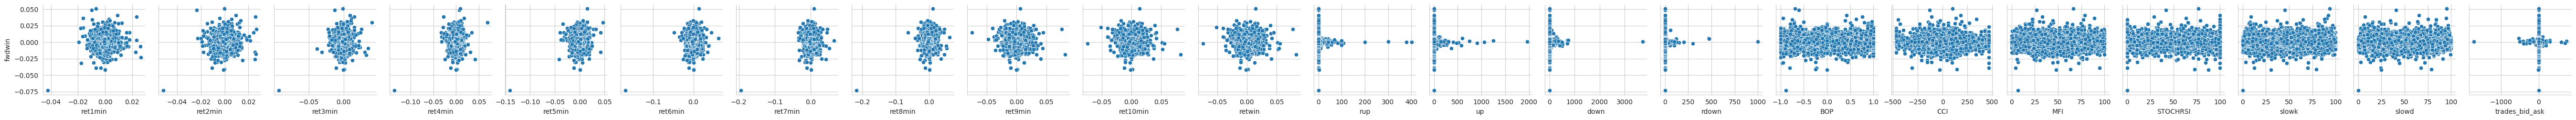

In [71]:
sns.pairplot(sample, y_vars=['fwdwin'], x_vars=features);

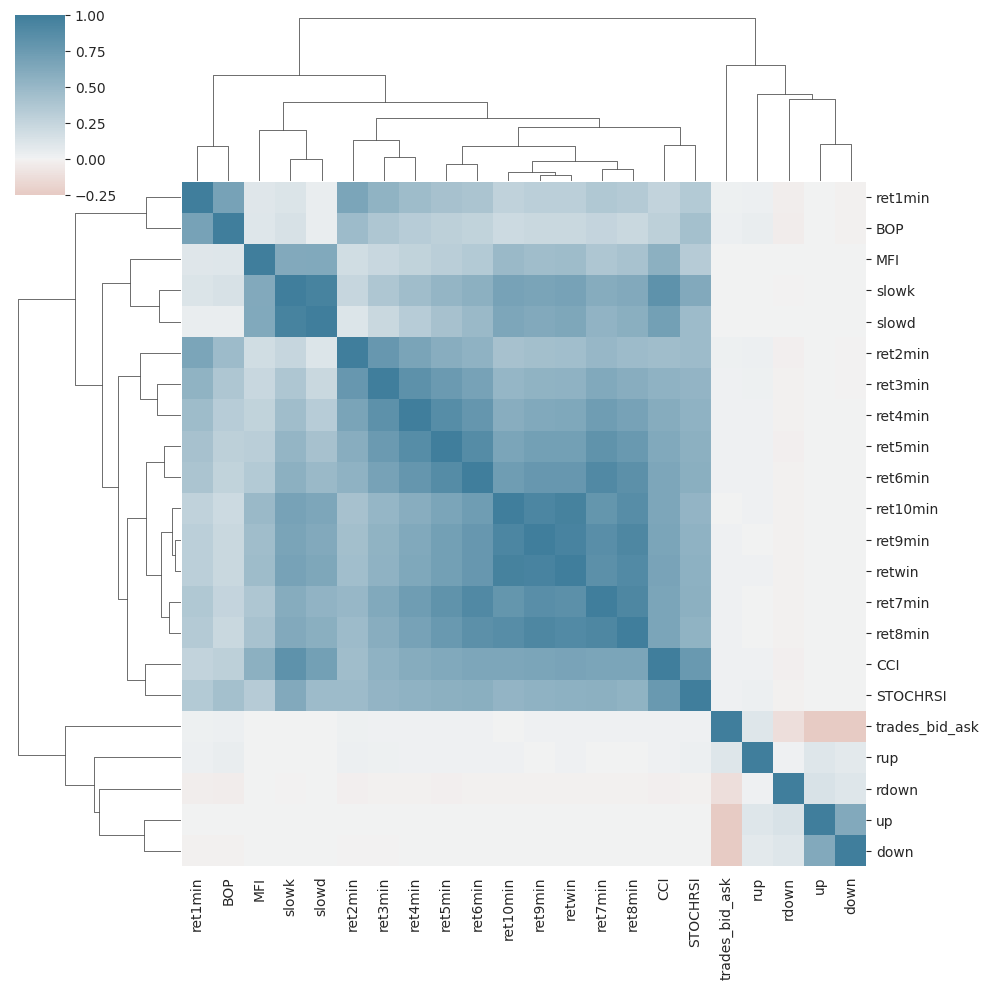

In [72]:
corr = sample.loc[:, features].corr()
sns.clustermap(corr, cmap = sns.diverging_palette(20, 230, as_cmap=True),
              center=0, vmin=-.25);

In [73]:
def spearmanr(preds: np.ndarray, labels: np.ndarray):
    """Custom IC eval metric for lightgbm"""
    t_preds = cudf.Series(preds)
    t_labels = cudf.Series(labels)
    return t_preds.corr(t_labels)


ic = {}
for feature in tqdm(features):
    df = data[['fwdwin', feature]].dropna()
    by_day = df.groupby(df.index.get_level_values('date_time').date) # calc per min is very time-consuming
    ic[feature] = by_day.apply(lambda x: spearmanr(x.fwdwin, x[feature])).mean()
ic = pd.Series(ic)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [05:02<00:00, 13.74s/it]


In [74]:
ic.sort_values()

ret10min         -0.024668
ret9min          -0.024115
ret8min          -0.023862
ret7min          -0.023177
ret6min          -0.022793
ret5min          -0.022369
ret4min          -0.021258
retwin           -0.020902
ret3min          -0.019661
ret2min          -0.017124
CCI              -0.015861
slowk            -0.015363
MFI              -0.014766
slowd            -0.014278
ret1min          -0.014008
STOCHRSI         -0.009295
BOP              -0.008134
rup              -0.001074
trades_bid_ask   -0.000668
rdown             0.000528
down              0.000597
up                0.001399
dtype: float64

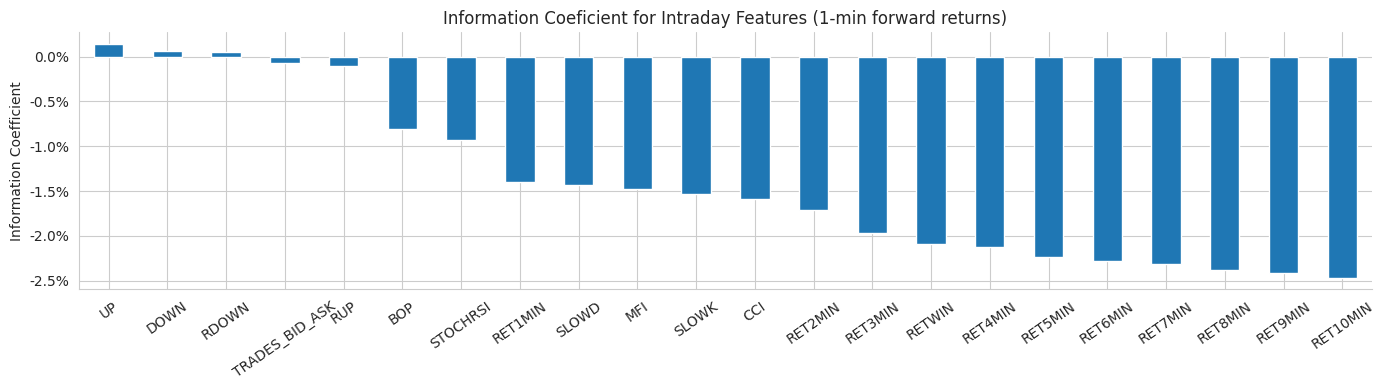

In [75]:
title = 'Information Coeficient for Intraday Features (1-min forward returns)'
ic.index = ic.index.map(str.upper)
ax = ic.sort_values(ascending=False).plot.bar(figsize=(14, 4), title=title, rot=35)
ax.set_ylabel('Information Coefficient')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
sns.despine()
plt.tight_layout();

### Store results

In [76]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 13452358 entries, ('AAL', Timestamp('2015-01-02 09:30:00')) to ('YHOO', Timestamp('2017-06-16 12:20:00'))
Data columns (total 26 columns):
 #   Column          Non-Null Count     Dtype  
---  ------          --------------     -----  
 0   date            13452358 non-null  int64  
 1   minute          13452358 non-null  int64  
 2   ret1min         13350557 non-null  float64
 3   ret2min         13180747 non-null  float64
 4   ret3min         13102981 non-null  float64
 5   ret4min         13025556 non-null  float64
 6   ret5min         12949249 non-null  float64
 7   ret6min         12871879 non-null  float64
 8   ret7min         12793437 non-null  float64
 9   ret8min         12715802 non-null  float64
 10  ret9min         12638377 non-null  float64
 11  ret10min        12560968 non-null  float64
 12  retwin          12560968 non-null  float64
 13  fwdwin          13452358 non-null  float64
 14  up              13139376 non-null  flo

In [77]:
data.drop(['date', 'up', 'down'], axis=1).to_hdf(algoseek_path, 'model_data')